#### Importing Libraries

In [1]:
%matplotlib inline
from keras.models import *
from keras.layers import *
from keras.regularizers import l2
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from scipy.io import loadmat
import cv2
import matplotlib.pyplot as plt
from PIL import Image

Using TensorFlow backend.


#### FCN8 Model

In [2]:
# Classes
classes = 21
# Image size
height, width = (224, 224)
# Image input - Tensorflow format
imgInput = Input(batch_shape=(None, height, width, 3))
# Image format - Tensorflow dataflow convention
IMAGE_ORDERING = 'channels_last'
# Convolution block 1
conv1_1 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1', data_format=IMAGE_ORDERING )(imgInput)
conv1_2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2', data_format=IMAGE_ORDERING )(conv1_1)
block1_pool = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING )(conv1_2)
# Convolution block 2
conv2_1 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1', data_format=IMAGE_ORDERING )(block1_pool)
conv2_2 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2', data_format=IMAGE_ORDERING )(conv2_1)
block2_pool = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING )(conv2_2)
# Convolution block 3
conv3_1 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1', data_format=IMAGE_ORDERING )(block2_pool)
conv3_2 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2', data_format=IMAGE_ORDERING )(conv3_1)
conv3_3 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3', data_format=IMAGE_ORDERING )(conv3_2)
block3_pool = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', data_format=IMAGE_ORDERING )(conv3_3)
# Convolution block 4
conv4_1 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1', data_format=IMAGE_ORDERING )(block3_pool)
conv4_2 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2', data_format=IMAGE_ORDERING )(conv4_1)
conv4_3 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_3', data_format=IMAGE_ORDERING )(conv4_2)
block4_pool = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format=IMAGE_ORDERING )(conv4_3)
# Convolution block 5
conv5_1 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_1', data_format=IMAGE_ORDERING )(block4_pool)
conv5_2 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_2', data_format=IMAGE_ORDERING )(conv5_1)
conv5_3 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_3', data_format=IMAGE_ORDERING )(conv5_2)
block5_pool = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format=IMAGE_ORDERING )(conv5_3)
# Convolutionalized fully connected layers
fc6 = (Conv2D(4096, (7, 7), activation='relu', padding="same", data_format=IMAGE_ORDERING, name='fc6'))(block5_pool)
fc6 = Dropout(0.5)(fc6)
fc7 = (Conv2D(4096, (1, 1), activation='relu', padding="same", data_format=IMAGE_ORDERING, name='fc7'))(fc6)
fc7 = Dropout(0.5)(fc7)
# Transform all the features to the individual classes
score_fr = (Conv2D(classes, (1, 1), activation='relu', padding='same', data_format=IMAGE_ORDERING, name='score_fr'))(fc7)
score2 = Deconvolution2D(classes, (4, 4), strides=(2, 2), activation=None, padding='valid', data_format=IMAGE_ORDERING, name='score2')(score_fr)
score2Crop = Cropping2D(cropping = 1)(score2)
# Score pool 4
score_pool4 = Conv2D(classes, (1, 1), activation=None, padding="same", name="score_pool4")(block4_pool)
# Merge
add1 = add(inputs = [score2Crop, score_pool4])
# Upsample after merge
score4 = Deconvolution2D(classes, (4, 4), strides=(2, 2), activation=None, padding="valid", name="score4")(add1)
score4Crop = Cropping2D(cropping = 1)(score4)
# Score pool 3
score_pool3 = Convolution2D(classes, (1, 1), activation=None, padding="same", name="score_pool3")(block3_pool)
# Merge
add2 = add(inputs = [score4Crop, score_pool3])
upsample = Deconvolution2D(classes, (16, 16), strides=(8, 8), activation=None, padding="valid", name="upsample")(add2)
output = Cropping2D(cropping=4)(upsample)
# Activation
output = (Activation('softmax'))(output)
# Model summary
FCN8 = Model(imgInput, output)
FCN8.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1_1 (Conv2D)                 (None, 224, 224, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
conv1_2 (Conv2D)                 (None, 224, 224, 64)  36928       conv1_1[0][0]                    
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0           conv1_2[0][0]                    
___________________________________________________________________________________________

#### Preprocessing data for training
Using VOC2011 Dataset http://host.robots.ox.ac.uk/pascal/VOC/voc2011/index.html

In [3]:
# Directory needed
val_image_dir = '/Users/Andrew/Documents/School/CS_6831/Project/VOC2011/JPEGImages/'
val_target_dir = '/Users/Andrew/Documents/School/CS_6831/Project/VOC2011/SegmentationClass/'
trainText = '/Users/Andrew/Documents/School/CS_6831/Project/VOC2011/ImageSets/Segmentation/train.txt'
validText = '/Users/Andrew/Documents/School/CS_6831/Project/VOC2011/ImageSets/Segmentation/trainval.txt'

# Getting training names in the train.txt
filenames_f = open(trainText, "r")
filenames = []
for line in filenames_f:
    line = line.strip()
    filenames.append(line)
filenames_f.close()   
print('~~Training dataset~~')
# Display number of training names
print('Number of training names:', len(filenames))
# Grab training dataset
images = []
for i in range(len(filenames)):
    images.append(val_image_dir + filenames[i] + '.jpg')
images.sort()
print('Number of test images:', len(images))
# Grab ground truth dataset
segmentations = []
for i in range(len(filenames)):
    segmentations.append(val_target_dir + filenames[i] + '.png')
segmentations.sort()
print('Number of ground truth images:', len(segmentations))
# Getting validation names in the trainval.txt
print('~~Validation dataset~~')
filenames_f = open(validText, "r")
filenamesV = []
for line in filenames_f:
    line = line.strip()
    filenamesV.append(line)
filenames_f.close()
print('Number of validation names:', len(filenamesV))
# Grab validation dataset
vimages = []
for i in range(len(filenamesV)):
    vimages.append(val_image_dir + filenamesV[i] + '.jpg')
vimages.sort()
print('Number of ground truth images for validation:', len(vimages))

~~Training dataset~~
Number of training names: 1112
Number of test images: 1112
Number of ground truth images: 1112
~~Validation dataset~~
Number of validation names: 2223
Number of ground truth images for validation: 2223


#### Turn input data into shape (1, height, width, RGB)
#### Turn ground truth data into shape (1, height, width, classes)

In [4]:
# From ground truth image (height, width, 3) -> (1, height, width, classes)
def binarylab(labels, size, nb_class):
    y = np.zeros((size,size, nb_class))
    for i in range(size):
        for j in range(size):
            y[i, j, labels[i][j]] = 1
    return y

def load_data(path, size, label=None):
    img = Image.open(path)
    w, h = img.size
    # Resize to the right ratio
    if w < h:
        if w < size:
            img = img.resize((size, size * h // w))
            w, h = img.size
    else:
        if h < size:
            img = img.resize((size * w // h, size))
            w, h = img.size
    img = img.resize((size, size))
    # If Y
    if label:
        y = np.array(img, dtype=np.int32)
        mask = y == 255
        y[mask] = 0
        y = binarylab(y, size, 21)
        y = np.expand_dims(y, axis = 0)
        return y
    # If X
    else:
        X = image.img_to_array(img)
        X = np.expand_dims(X, axis = 0)
        X = preprocess_input(X)
        return X

def generate_arrays_from_file(names, path_to_train, path_to_target, img_size, nb_class):
    while True:
        for name in names:
            Xpath = path_to_train + "{}.jpg".format(name)
            ypath = path_to_target + "{}.png".format(name)
            X = load_data(Xpath, img_size, label = False)
            y = load_data(ypath, img_size, label = True)
            yield np.array(X) , np.array(y)

In [5]:
# Test generator function
X = generate_arrays_from_file(filenames, val_image_dir, val_target_dir, width, classes)
X_get = next(X)
print('Input - Shape:', X_get[0].shape)
print('Ground Truth - Shape:', X_get[1].shape)

Input - Shape: (1, 224, 224, 3)
Ground Truth - Shape: (1, 224, 224, 21)


In [6]:
def mean_categorical_crossentropy(y_true, y_pred):
    if K.image_data_format() == 'channels_last':
        loss = K.mean(keras.losses.categorical_crossentropy(y_true, y_pred), axis=[1, 2])
    elif K.image_data_format() == 'channels_first':
        loss = K.mean(keras.losses.categorical_crossentropy(y_true, y_pred), axis=[2, 3])
    print(loss)
    return loss

In [7]:
FCN8.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
# FCN8.compile(loss=mean_categorical_crossentropy, optimizer='adagrad', metrics=['accuracy'])

#### Training
Having problems getting model to learn

In [8]:
# # Variables
# classes = 21
# epochs = 100
# nb_data = len(filenames)
# nbv_data = len(filenamesV)

# FCN8.fit_generator(generator=generate_arrays_from_file(filenames, val_image_dir, val_target_dir, width, classes),
#                     steps_per_epoch=nb_data,
# #                     validation_data=generate_arrays_from_file(filenamesV, val_image_dir, val_target_dir, width, classes),
# #                     validation_steps=nbv_data,
#                     epochs=epochs)

#### Loading Pretrained model for FCN8 from MatConvNet
http://www.vlfeat.org/matconvnet/pretrained/#semantic-segmentation

In [9]:
USETVG = True
if USETVG:
    data = loadmat('pascal-fcn8s-tvg-dag.mat', matlab_compatible=False, struct_as_record=False)
    l = data['layers']
    p = data['params']
    description = data['meta'][0,0].classes[0,0].description
else:
    data = loadmat('pascal-fcn8s-dag.mat', matlab_compatible=False, struct_as_record=False)
    l = data['layers']
    p = data['params']
    description = data['meta'][0,0].classes[0,0].description
    print(data.keys())


def copy_mat_to_keras(kmodel, verbose=True):
    kerasnames = [lr.name for lr in kmodel.layers]
    # Format for tensorflow
    prmt = (0, 1, 2, 3)
    for i in range(0, p.shape[1]):
        if USETVG:
            matname = p[0,i].name[0][0:-1]
            matname_type = p[0,i].name[0][-1] # "f" for filter weights or "b" for bias
        else:
            matname = p[0,i].name[0].replace('_filter','').replace('_bias','')
            matname_type = p[0,i].name[0].split('_')[-1] # "filter" or "bias"
        
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            if verbose:
                print ('found : ', (str(matname), str(matname_type), kindex))
            assert (len(kmodel.layers[kindex].get_weights()) == 2)
            if  matname_type in ['f','filter']:
                l_weights = p[0,i].value
                f_l_weights = l_weights.transpose(prmt)
                f_l_weights = np.flip(f_l_weights, 2)
                f_l_weights = np.flip(f_l_weights, 3)
                assert (f_l_weights.shape == kmodel.layers[kindex].get_weights()[0].shape)
                current_b = kmodel.layers[kindex].get_weights()[1]
                kmodel.layers[kindex].set_weights([f_l_weights, current_b])
            elif matname_type in ['b','bias']:
                l_bias = p[0,i].value
                assert (l_bias.shape[1] == 1)
                assert (l_bias[:,0].shape == kmodel.layers[kindex].get_weights()[1].shape)
                current_f = kmodel.layers[kindex].get_weights()[0]
                kmodel.layers[kindex].set_weights([current_f, l_bias[:,0]])
        else:
            print ('not found : ', str(matname))
            
copy_mat_to_keras(FCN8, True)

found :  ('conv1_1', 'f', 1)
found :  ('conv1_1', 'b', 1)
found :  ('conv1_2', 'f', 2)
found :  ('conv1_2', 'b', 2)
found :  ('conv2_1', 'f', 4)
found :  ('conv2_1', 'b', 4)
found :  ('conv2_2', 'f', 5)
found :  ('conv2_2', 'b', 5)
found :  ('conv3_1', 'f', 7)
found :  ('conv3_1', 'b', 7)
found :  ('conv3_2', 'f', 8)
found :  ('conv3_2', 'b', 8)
found :  ('conv3_3', 'f', 9)
found :  ('conv3_3', 'b', 9)
found :  ('conv4_1', 'f', 11)
found :  ('conv4_1', 'b', 11)
found :  ('conv4_2', 'f', 12)
found :  ('conv4_2', 'b', 12)
found :  ('conv4_3', 'f', 13)
found :  ('conv4_3', 'b', 13)
found :  ('conv5_1', 'f', 15)
found :  ('conv5_1', 'b', 15)
found :  ('conv5_2', 'f', 16)
found :  ('conv5_2', 'b', 16)
found :  ('conv5_3', 'f', 17)
found :  ('conv5_3', 'b', 17)
found :  ('fc6', 'f', 19)
found :  ('fc6', 'b', 19)
found :  ('fc7', 'f', 21)
found :  ('fc7', 'b', 21)
found :  ('score_fr', 'f', 23)
found :  ('score_fr', 'b', 23)
found :  ('score2', 'f', 24)
found :  ('score2', 'b', 24)
found :  (

#### Prediction

In [10]:
# Create color map
def prepareim(im):
    im[:,:,0] -= 103.939
    im[:,:,1] -= 116.779
    im[:,:,2] -= 123.68
    # Tacks on 1 in the front to follow formatting
    im = np.expand_dims(im, axis=0)
    return im

# Intersection over Union
def computeIoU(y_pred_batch, y_true_batch):
    return np.mean(np.asarray([pixelAccuracy(y_pred_batch[i], y_true_batch[i]) for i in range(len(y_true_batch))])) 

def pixelAccuracy(y_pred, y_true):
    y_pred = np.argmax(np.reshape(y_pred,[224, 224, 21]),axis=2)
    y_true = np.argmax(np.reshape(y_true,[224, 224, 21]),axis=2)
    y_pred = y_pred * (y_true > 0)

    return 1.0 * np.sum((y_pred==y_true)*(y_true>0)) /  np.sum(y_true>0)

Image number: 136


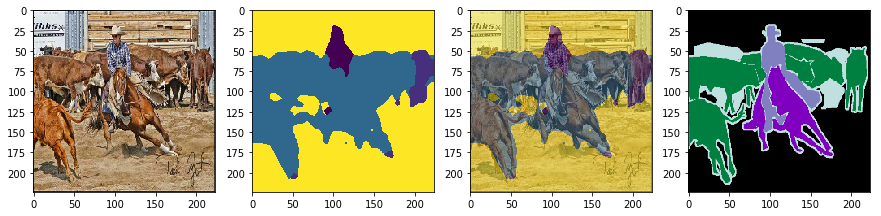

IOU: 0.521756764587


In [11]:
# Pick random image
subset = filenames[0: len(filenames)]
S = np.random.choice(len(filenames))
S = 136
print('Image number:', S)
# Imput Image
inputImg = cv2.imread(images[S])
inputImg = cv2.resize(inputImg, (224, 224))
# Ready input image to feed into model
inputImgP = inputImg.astype('float32')
inputImgP = prepareim(inputImgP)
preds = FCN8.predict(inputImgP)
imclass = np.argmax(preds, axis=3)[0,:,:]
plt.figure(figsize = (15, 7))
# Input Image
plt.subplot(1, 4, 1)
inputImg = cv2.cvtColor(inputImg, cv2.COLOR_BGR2RGB)
plt.imshow(np.asarray(inputImg))
# Class Image
plt.subplot(1, 4, 2)
plt.imshow(imclass)
# Input Image with Class Image (Mask)
plt.subplot(1, 4, 3)
plt.imshow(np.asarray(inputImg))
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
# plt.imshow(imclass, alpha = 0.5)
plt.imshow(masked_imclass, alpha = 0.5)
# Ground Truth
plt.subplot(1, 4, 4)
segImg = cv2.imread(segmentations[S])
segImg = cv2.resize(segImg, (224, 224))
plt.imshow(np.asarray(segImg))

plt.show()

groundTruth = load_data(segmentations[S], 224, label=True)
print('IOU:', computeIoU(preds, groundTruth))